In [1]:
%cd ..

/home/burak/repos/smartrag


/home/burak/repos/smartrag/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from disambiguation_methods.qa import chain_answer, IS_BOOL
from disambiguation_methods.score import chain_score
from disambiguation_methods.score_2 import chain_score as chain_score2

from collections import defaultdict
from disambiguation_methods.qa import AnswerStr
from disambiguation_methods.score import AnswerJudge
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableConfig
from models import QueryAmbiguation
import pandas as pd
import json
from disambiguation_methods.domain_extractor import categories

from tqdm import tqdm

In [3]:
top_n = 10
dataset_name = "unfiltered/pubmed-qa"
# experiment = f"ambiguous_top{top_n}+DOMAIN+Intent+Dtype+MLM+TE+LLM"
experiment = "unfiltered+DOMAIN+Intent+Dtype"
llm_name = "gpt35"

In [4]:
df = pd.read_csv(f"./data/{dataset_name}_{experiment}.csv")

### Ambiguity Experiments

In [278]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["amb"]) if x["amb"] is not None else None)
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["unamb"]) if x["unamb"] is not None else None)
lm3 = RunnableLambda(lambda x: chain_answer.invoke(x["disamb"]))
chain_ = RunnableParallel(amb=lm1, unamb=lm2, disamb=lm3)

In [279]:
methods = [
    "MLM",
    "TE",
    "LLMSelection",
    "LLMSelection_NO_INTENT",
    "LLMSelection_NO_DOMAIN",
    "LLMSelection_NO_DTYPE",
    "LLMSuggestion",
]

In [280]:
llm_name = "gpt35"
n_runs = 4

In [ ]:
for method_idx, method in enumerate(methods[2:], 2):
    for run_idx in range(n_runs):
        for df_index in tqdm(range(len(df))):
            ambiguities = QueryAmbiguation(**json.loads(df.loc[df_index, "possible_ambiguities"]))
            if "LLMSuggestion" not in method:
                most_likely_full_forms: list[str] = json.loads(
                    df.loc[df_index, f"{method.split("_")[0] if "LLM" not in method else "LLM"}_most_likely_full_forms"]
                )
            else:
                most_likely_full_forms: list[str] = json.loads(df.loc[df_index, f"llm_full_form_suggestions"])

            disambiguated_question_answers = []
            unambiguous_question_answers = []
            ambiguous_question_answers = []

            evaluation = {"amb": [], "disamb": [], "unamb": []}

            # if len(most_likely_full_forms) == 1:
            #     continue

            for amb_idx, (full_form, amb) in enumerate(zip(most_likely_full_forms, ambiguities.full_form_abbrv_map)):
                amb_question: str = df.loc[df_index, "ambiguous_question"]
                unamb_question: str = df.loc[df_index, "unambiguous_question"]

                disambiguated_question = amb_question.replace(amb.abbreviation, amb.abbreviation + f" ({full_form})")
                df.loc[df_index, "disambiguated_question"] = disambiguated_question

                response: dict[str, AnswerStr] = chain_.invoke(
                    {
                        "amb": (
                            {
                                "query": amb_question,
                                "intent": df.loc[df_index, "intent"]
                                if "NO_INTENT" not in method
                                else "'Not Specified'",
                                "domain": df.loc[df_index, "domain"]
                                if "NO_DOMAIN" not in method
                                else "'Not Specified'",
                                "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                            }
                        )
                        if f"{methods[method_idx - 1]}_{run_idx-1}_ambiguous_question_answered_by_{llm_name}_correct"
                        not in df.columns
                        else None,
                        "unamb": (
                            {
                                "query": unamb_question,
                                "intent": df.loc[df_index, "intent"]
                                if "NO_INTENT" not in method
                                else "'Not Specified'",
                                "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                                "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                            }
                        )
                        if f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}_correct"
                        not in df.columns
                        else None,
                        "disamb": {
                            "query": disambiguated_question,
                            "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                            "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                            "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                        },
                    },
                    RunnableConfig(configurable={"llm": "gpt35"}),
                )

                response_: AnswerJudge = chain_score.invoke(
                    {
                        "answer": df.loc[df_index, "answer"]
                        if "answer" in df.columns
                        else (
                            (response["unamb"].answer)
                            if f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}"
                            not in df.columns
                            else json.loads(
                                df.loc[
                                    df_index,
                                    f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}",
                                ]
                            )[amb_idx]
                        ),
                        "amb": (
                            (response["amb"].answer)
                            if f"{methods[method_idx - 1]}_{run_idx}_ambiguous_question_answered_by_{llm_name}"
                            not in df.columns
                            else json.loads(
                                df.loc[
                                    df_index,
                                    f"{methods[method_idx - 1]}_{run_idx}_ambiguous_question_answered_by_{llm_name}",
                                ]
                            )[amb_idx]
                        ),
                        "unamb": (
                            (response["unamb"].answer)
                            if f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}"
                            not in df.columns
                            else json.loads(
                                df.loc[
                                    df_index,
                                    f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}",
                                ]
                            )[amb_idx]
                        ),
                        "disamb": response["disamb"].answer,
                        "query": unamb_question,
                    }
                )

                # amb, unamb, disamb

                disambiguated_question_answers.append(response["disamb"].answer)
                unambiguous_question_answers.append(
                    response["unamb"].answer
                    if f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}"
                    not in df.columns
                    else json.loads(
                        df.loc[
                            df_index, f"{methods[method_idx - 1]}_{run_idx}_unambiguous_question_answered_by_{llm_name}"
                        ]
                    )[amb_idx]
                )
                ambiguous_question_answers.append(
                    response["amb"].answer
                    if f"{methods[method_idx - 1]}_{run_idx}_ambiguous_question_answered_by_{llm_name}"
                    not in df.columns
                    else json.loads(
                        df.loc[
                            df_index, f"{methods[method_idx - 1]}_{run_idx}_ambiguous_question_answered_by_{llm_name}"
                        ]
                    )[amb_idx]
                )

                evaluation["amb"].append(response_.bit1 == 1)
                evaluation["unamb"].append(response_.bit2 == 1)
                evaluation["disamb"].append(response_.bit3 == 1)

            df.loc[df_index, f"{method}_{run_idx}_disambiguated_question_answered_by_{llm_name}_correct"] = json.dumps(
                evaluation["disamb"]
            )
            df.loc[df_index, f"{method}_{run_idx}_unambiguous_question_answered_by_{llm_name}_correct"] = json.dumps(
                evaluation["unamb"]
            )
            df.loc[df_index, f"{method}_{run_idx}_ambiguous_question_answered_by_{llm_name}_correct"] = json.dumps(
                evaluation["amb"]
            )
            df.loc[df_index, f"{method}_{run_idx}_disambiguated_question_answered_by_{llm_name}"] = json.dumps(
                disambiguated_question_answers
            )
            df.loc[df_index, f"{method}_{run_idx}_unambiguous_question_answered_by_{llm_name}"] = json.dumps(
                unambiguous_question_answers
            )
            df.loc[df_index, f"{method}_{run_idx}_ambiguous_question_answered_by_{llm_name}"] = json.dumps(
                ambiguous_question_answers
            )

        df.to_csv(f"./data/{dataset_name}_{experiment}_{run_idx}.csv", index=False)

In [287]:
# df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv", index=False)

In [297]:
import numpy as np

eval_df = pd.DataFrame(
    columns=[
        "dataset_name",
        "method",
        "ambiguous_accuracy",
        "ambiguous_accuracy_std",
        "unambiguous_accuracy",
        "unambiguous_accuracy_std",
        "disambiguated_accuracy",
        "disambiguated_accuracy_std",
    ]
)
from glob import glob

for file in glob("./data/ambiguity/*eval.csv"):
    dataset_name = file.split("_")[0].split("/")[-1]
    df = pd.read_csv(file)
    for method in methods:
        if any(map(lambda x: method in x, df.columns)):
            for run_idx in range(n_runs):
                df[f"{method}_{run_idx}_ambiguous_question_answered_by_gpt35_correct"] = df[
                    f"{method}_{run_idx}_ambiguous_question_answered_by_gpt35_correct"
                ].apply(lambda x: np.mean(json.loads(x)))
                df[f"{method}_{run_idx}_unambiguous_question_answered_by_gpt35_correct"] = df[
                    f"{method}_{run_idx}_unambiguous_question_answered_by_gpt35_correct"
                ].apply(lambda x: np.mean(json.loads(x)))
                df[f"{method}_{run_idx}_disambiguated_question_answered_by_gpt35_correct"] = df[
                    f"{method}_{run_idx}_disambiguated_question_answered_by_gpt35_correct"
                ].apply(lambda x: np.mean(json.loads(x)))

    for method in methods:
        if any(map(lambda x: method in x, df.columns)):
            eval_df = pd.concat(
                [
                    eval_df,
                    pd.DataFrame(
                        [
                            {
                                "dataset_name": dataset_name,
                                "method": method,
                                "ambiguous_accuracy": df[
                                    [
                                        f"{method_}_{run_idx}_ambiguous_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                .mean()
                                .mean(),
                                "ambiguous_accuracy_std": df[
                                    [
                                        f"{method_}_{run_idx}_ambiguous_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                .mean()
                                .std(),
                                "unambiguous_accuracy": df[
                                    [
                                        f"{method_}_{run_idx}_unambiguous_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                .mean()
                                .mean(),
                                "unambiguous_accuracy_std": df[
                                    [
                                        f"{method_}_{run_idx}_unambiguous_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                .mean()
                                .std(),
                                "disambiguated_accuracy": df[
                                    [
                                        f"{method}_{run_idx}_disambiguated_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                    ]
                                ]
                                .mean()
                                .mean(),
                                "disambiguated_accuracy_std": df[
                                    [
                                        f"{method}_{run_idx}_disambiguated_question_answered_by_gpt35_correct"
                                        for run_idx in range(n_runs)
                                    ]
                                ]
                                .mean()
                                .std(),
                            }
                        ]
                    ),
                ],
                ignore_index=True,
            )
eval_df

/tmp/ipykernel_838/2863330329.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,dataset_name,method,ambiguous_accuracy,ambiguous_accuracy_std,unambiguous_accuracy,unambiguous_accuracy_std,disambiguated_accuracy,disambiguated_accuracy_std
0,ai,MLM,0.843333,0.014229,0.950952,0.010767,0.660000,0.007698
1,ai,TE,0.843333,0.014229,0.950952,0.010767,0.755000,0.012620
2,ai,LLMSelection,0.843333,0.014229,0.950952,0.010767,0.840000,0.005443
3,ai,LLMSelection_NO_INTENT,0.843333,0.014229,0.950952,0.010767,0.806667,0.018053
4,ai,LLMSelection_NO_DOMAIN,0.843333,0.014229,0.950952,0.010767,0.848333,0.023960
5,ai,LLMSelection_NO_DTYPE,0.843333,0.014229,0.950952,0.010767,0.843333,0.016777
6,ai,LLMSuggestion,0.843333,0.014229,0.950952,0.010767,0.856667,0.027487
7,medquad,MLM,0.594265,0.007383,0.865470,0.011360,0.489183,0.016712
8,medquad,TE,0.594265,0.007383,0.865470,0.011360,0.550481,0.013879
9,medquad,LLMSelection,0.594265,0.007383,0.865470,0.011360,0.658654,0.018307


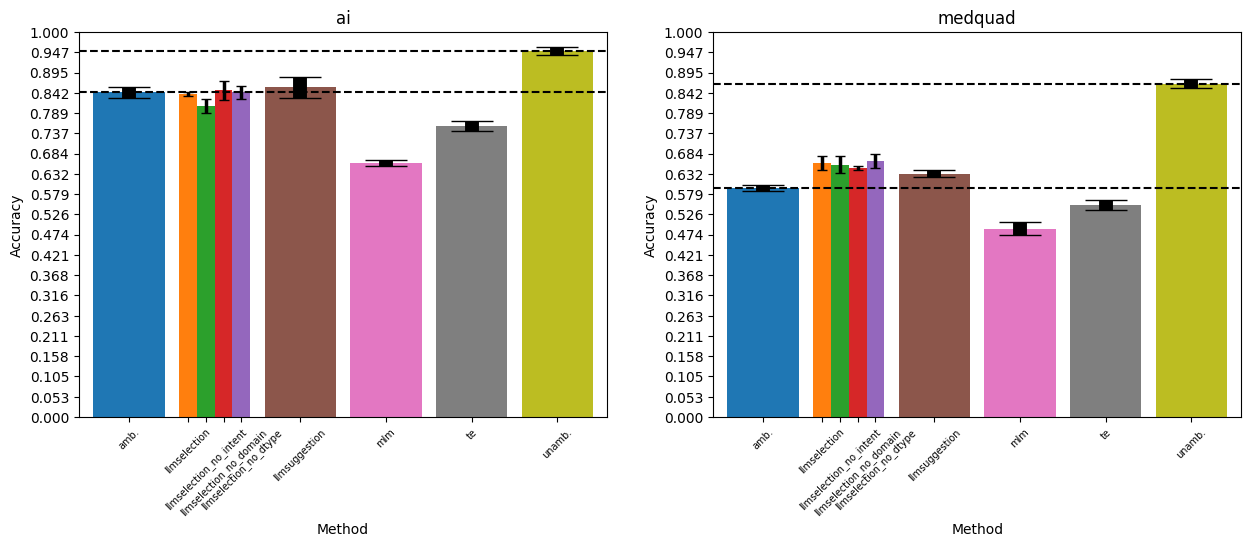

In [304]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, eval_df["dataset_name"].nunique(), squeeze=False, figsize=(15, 5))
for axs, (_, group_df) in zip(axes.T, eval_df.groupby(by="dataset_name")):
    axs[0].bar([0], [group_df.iloc[0]["ambiguous_accuracy"]], label="amb.", width=0.25, align="edge")
    axs[0].errorbar(
        [0.25 / 2],
        [group_df.iloc[0]["ambiguous_accuracy"]],
        [group_df.iloc[0]["ambiguous_accuracy_std"]],
        capsize=15,
        elinewidth=10,
        color="black",
    )
    ticks = [(0.25 / 2, "amb.")]

    group_df["method_name"] = group_df["method"].apply(lambda x: x.split("_")[0])

    last_end_pos = 0.25
    bar_spacing = 0.05
    for method_idx, (_, method_df) in enumerate(group_df.groupby(by="method_name")):
        width = 0.25 / (len(method_df))
        last_end_pos += bar_spacing
        for row_idx, (_, row) in enumerate(method_df.iterrows()):
            axs[0].bar(
                [last_end_pos + width * row_idx],
                [row["disambiguated_accuracy"]],
                label=f"{row['method']}_disamb.",
                width=width,
                align="edge",
            )
            axs[0].errorbar(
                [last_end_pos + width * row_idx + width / 2],
                [row["disambiguated_accuracy"]],
                [row["disambiguated_accuracy_std"]],
                capsize=15 / len(method_df),
                elinewidth=10 / len(method_df),
                color="black",
            )
            ticks.append((last_end_pos + width * row_idx + width / 2, row["method"].casefold()))
        last_end_pos += 0.25

    last_end_pos += bar_spacing
    axs[0].bar(
        [last_end_pos],
        [group_df.iloc[0]["unambiguous_accuracy"]],
        label="unamb.",
        width=0.25,
        align="edge",
    )
    axs[0].errorbar(
        [last_end_pos + 0.25 / 2],
        [group_df.iloc[0]["unambiguous_accuracy"]],
        [group_df.iloc[0]["unambiguous_accuracy_std"]],
        capsize=15,
        elinewidth=10,
        color="black",
    )

    ticks.append((last_end_pos + 0.25 / 2, "unamb."))
    axs[0].set_xticks(list(map(lambda x: x[0], ticks)), list(map(lambda x: x[1], ticks)), rotation=45, fontsize=7)
    axs[0].set_yticks(np.linspace(0, 1, num=20))
    axs[0].set_title(group_df.iloc[0]["dataset_name"])
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Method")
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(-0.05, last_end_pos + 0.30)
    axs[0].plot(
        [-0.05, last_end_pos + 0.30],
        [group_df.iloc[0]["ambiguous_accuracy"], group_df.iloc[0]["ambiguous_accuracy"]],
        color="black",
        linestyle="--",
    )
    axs[0].plot(
        [-0.05, last_end_pos + 0.30],
        [group_df.iloc[0]["unambiguous_accuracy"], group_df.iloc[0]["unambiguous_accuracy"]],
        color="black",
        linestyle="--",
    )


plt.savefig("./data/figs/ambiguity.pdf", bbox_inches="tight")
plt.show()

### Intent+Domain+Dtype Experiments

In [5]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["raw"]) if x["raw"] is not None else None)
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["analyzed"]))
chain_ = RunnableParallel(raw=lm1, analyzed=lm2)

In [6]:
methods = [
    "RAW_ALL",
    "RAW_NO_DTYPE",
    "RAW_NO_DOMAIN",
    "RAW_NO_INTENT",
]

In [7]:
n_runs = 5

In [8]:
from disambiguation_methods.qa import AnswerBool

llm_name = "gpt35"

for method_idx, method in enumerate(methods):
    for run_idx in range(n_runs):
        for df_index in tqdm(range(len(df))):
            question: str = df.loc[df_index, "question"]
            answer: str | bool = df.loc[df_index, "answer"] if "answer" in df else ""

            response: dict[str, AnswerStr | AnswerBool] = chain_.invoke(
                {
                    "analyzed": {
                        "query": question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                        "domain": df.loc[df_index, "domain"] if "NO_DOMAIN" not in method else "'Not Specified'",
                        "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                    },
                    "raw": (
                        {
                            "query": question,
                            "intent": "'Not Specified'",
                            "domain": "'Not Specified'",
                            "dtype": "'Not specified'",
                        }
                    )
                    if f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}" not in df.columns
                    else None,
                },
                RunnableConfig(configurable={"llm": llm_name}),
            )
            if not IS_BOOL:
                response_: AnswerJudge = chain_score2.invoke(
                    {
                        "answer": answer
                        if answer
                        else (
                            (response["raw"].answer)
                            if f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}"
                            not in df.columns
                            else df.loc[
                                df_index, f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}"
                            ]
                        ),
                        "raw": (
                            (response["raw"].answer)
                            if f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}"
                            not in df.columns
                            else df.loc[
                                df_index, f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}"
                            ]
                        ),
                        "analyzed": response["analyzed"].answer,
                        "query": question,
                    }
                )

                df.loc[df_index, f"{method}_{run_idx}_raw_question_answered_by_{llm_name}_correct"] = (
                    response_.bit1 == 1
                )
                df.loc[df_index, f"{method}_{run_idx}_analyzed_question_answered_by_{llm_name}_correct"] = (
                    response_.bit2 == 1
                )
            else:
                df.loc[df_index, f"{method}_{run_idx}_raw_question_answered_by_{llm_name}_correct"] = (
                    (response["raw"].answer == answer)
                    if f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}_correct"
                    not in df.columns
                    else df.loc[
                        df_index, f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}_correct"
                    ]
                )
                df.loc[df_index, f"{method}_{run_idx}_analyzed_question_answered_by_{llm_name}_correct"] = (
                    response["analyzed"].answer == answer
                )

            df.loc[df_index, f"{method}_{run_idx}_analyzed_question_answered_by_{llm_name}"] = response[
                "analyzed"
            ].answer
            df.loc[df_index, f"{method}_{run_idx}_raw_question_answered_by_{llm_name}"] = (
                (response["raw"].answer)
                if f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}" not in df.columns
                else df.loc[df_index, f"{methods[method_idx - 1]}_{run_idx}_raw_question_answered_by_{llm_name}"]
            )

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [04:23<00:00,  1.75s/it]


In [9]:
df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv")

In [10]:
eval_df = pd.DataFrame(
    columns=["dataset_name", "method", "raw_accuracy", "raw_accuracy_std", "analyzed_accuracy", "analyzed_accuracy_std"]
)
from glob import glob

dataset_run = {"boolq": 5, "strategyqa": 6, "medquad": 5, "finqabench": 5, "meadow": 5, "pubmed-qa": 5}

for file in glob("./data/unfiltered/*eval.csv"):
    dataset_name = file.split("_")[0].split("/")[-1]
    print(dataset_name)
    n_runs = dataset_run[dataset_name]
    df = pd.read_csv(file)
    for method in methods:
        eval_df = pd.concat(
            [
                eval_df,
                pd.DataFrame(
                    [
                        {
                            "dataset_name": dataset_name,
                            "method": method,
                            "raw_accuracy": (
                                df[
                                    [
                                        f"{method_}_{run_idx}_raw_question_answered_by_{llm_name}_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                * 1.0
                            )
                            .mean()
                            .mean(),
                            "raw_accuracy_std": (
                                df[
                                    [
                                        f"{method_}_{run_idx}_raw_question_answered_by_{llm_name}_correct"
                                        for run_idx in range(n_runs)
                                        for method_ in methods
                                    ]
                                ]
                                * 1.0
                            )
                            .mean()
                            .std(),
                            "analyzed_accuracy": (
                                df[
                                    [
                                        f"{method}_{run_idx}_analyzed_question_answered_by_{llm_name}_correct"
                                        for run_idx in range(n_runs)
                                    ]
                                ]
                                * 1.0
                            )
                            .mean()
                            .mean(),
                            "analyzed_accuracy_std": (
                                df[
                                    [
                                        f"{method}_{run_idx}_analyzed_question_answered_by_{llm_name}_correct"
                                        for run_idx in range(n_runs)
                                    ]
                                ]
                                * 1.0
                            )
                            .mean()
                            .std(),
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )
eval_df

meadow
pubmed-qa
medquad


/tmp/ipykernel_7734/1983896484.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


boolq
finqabench
strategyqa


,dataset_name,method,raw_accuracy,raw_accuracy_std,analyzed_accuracy,analyzed_accuracy_std
0,meadow,RAW_ALL,0.799333,0.016316,0.868000,0.016600
1,meadow,RAW_NO_DTYPE,0.799333,0.016316,0.877333,0.013824
2,meadow,RAW_NO_DOMAIN,0.799333,0.016316,0.836000,0.017385
3,meadow,RAW_NO_INTENT,0.799333,0.016316,0.852000,0.013663
4,pubmed-qa,RAW_ALL,0.799000,0.011087,0.756000,0.018012
5,pubmed-qa,RAW_NO_DTYPE,0.799000,0.011087,0.872000,0.009888
6,pubmed-qa,RAW_NO_DOMAIN,0.799000,0.011087,0.477333,0.015348
7,pubmed-qa,RAW_NO_INTENT,0.799000,0.011087,0.754667,0.010954
8,medquad,RAW_ALL,0.893333,0.012978,0.878667,0.012824
9,medquad,RAW_NO_DTYPE,0.893333,0.012978,0.906667,0.008165


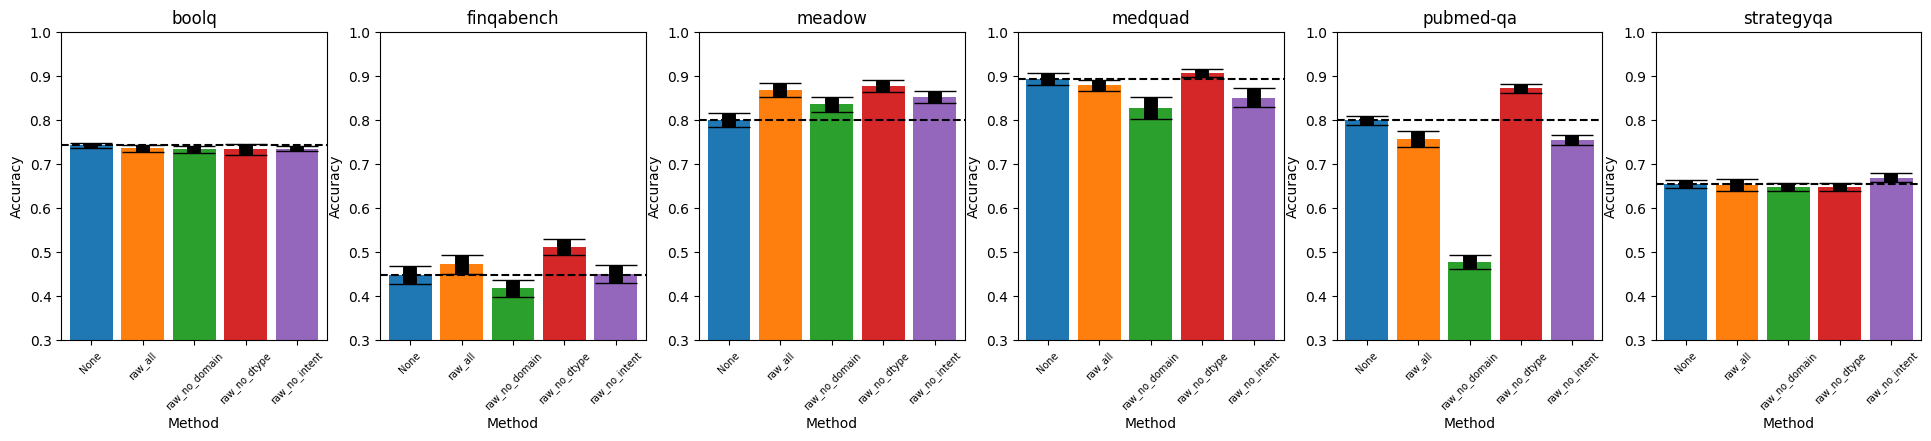

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    1, eval_df["dataset_name"].nunique(), figsize=(eval_df["dataset_name"].nunique() * 4, 4), squeeze=False
)

for ax, (i, group_df) in zip(axes.T, eval_df.groupby(by=["dataset_name"])):
    ax[0].bar([0], group_df.iloc[0]["raw_accuracy"], label="None", width=0.25, align="edge")
    ax[0].errorbar(
        [0.25 / 2],
        group_df.iloc[0]["raw_accuracy"],
        group_df.iloc[0]["raw_accuracy_std"],
        capsize=15,
        elinewidth=10,
        color="black",
    )
    ax[0].plot([-0.05, 3], [group_df.iloc[0]["raw_accuracy"]] * 2, color="black", linestyle="--")

    last_end_pos = 0.3
    bar_spacing = 0.05
    methods = []
    ticks = [(0.25 / 2, "None")]
    for idx, row in group_df.sort_values(by="method").iterrows():
        methods.append(row["method"])
        ticks.append((last_end_pos + 0.25 / 2, row["method"].casefold()))
        ax[0].bar(
            [last_end_pos],
            [row["analyzed_accuracy"]],
            label=row["method"],
            align="edge",
            width=0.25,
        )
        ax[0].errorbar(
            [last_end_pos + 0.25 / 2],
            [row["analyzed_accuracy"]],
            [row["analyzed_accuracy_std"]],
            capsize=15,
            elinewidth=10,
            color="black",
        )
        last_end_pos += 0.25 + bar_spacing

    ax[0].set_ylim(0.3, 1)
    ax[0].set_xlim(-0.05, last_end_pos)
    ax[0].set_title(row["dataset_name"])
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Method")
    ax[0].set_xticks(list(map(lambda x: x[0], ticks)), list(map(lambda x: x[1], ticks)), rotation=45, fontsize=7)
plt.savefig("./data/figs/unfiltered.pdf", bbox_inches="tight")
plt.show()

In [20]:
df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv", index=False)